In [1]:
################ Import packages ###################
#Basic
import numpy as np    # 1.24.4
import pandas as pd
import pickle
import random

#Plot
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set()    
%matplotlib inline

#Torch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

#SKlearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#SHAP
import shap     # 0.43.0
shap.initjs()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
##### import data #####
housing_modified = pd.read_csv("../data/housing_modified.csv")     # housing_modified is DataFrame
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns  

with open('bosten_data_split.pickle', 'rb') as f:
    indexs = pickle.load(f)
y_train_index, y_val_index, y_test_index = indexs

x_train= housing_modified.iloc[y_train_index][x_column_names]
x_val= housing_modified.iloc[y_val_index][x_column_names]
x_test= housing_modified.iloc[y_test_index][x_column_names]

y_train= housing_modified.iloc[y_train_index][y_column_names]
y_val= housing_modified.iloc[y_val_index][y_column_names]
y_test= housing_modified.iloc[y_test_index][y_column_names]

In [3]:
# calculate the standardation x_train
scaler_x = StandardScaler()
scaler_x.fit(x_train)

# give the standardization to all data
x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# same for y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

In [4]:
# canculate mean and standard-deviation
x_train_mean = x_train.mean()
x_train_STD = x_train.std()
y_train_mean = y_train.mean()
y_train_STD = y_train.std()

# reverse standardization
x_train_inv = scaler_x.inverse_transform(x_train_std)
y_train_inv = scaler_y.inverse_transform(y_train_std)
x_test_inv = scaler_x.inverse_transform(x_test_std)
y_test_inv = scaler_y.inverse_transform(y_test_std)

In [5]:
dopout_rate= 0.1   # 0.3

In [6]:
#####v Network structure ##### 
class FullyConnectedNuralNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNuralNetwork,self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=12,out_features= 100,bias=True),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                #nn.Dropout(p= 0.3), #add dropout
                nn.Linear(in_features=100,out_features=50,bias=True),
                nn.ReLU())
        
        self.predict=nn.Sequential(
                nn.Dropout(p= dopout_rate),
                nn.Linear(in_features= 50,out_features=1,bias=True))
                
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.predict(x)
        return x
    
testnet = FullyConnectedNuralNetwork().to(device)

In [7]:
##### definedatasets and dataloader
train_data= TensorDataset(torch.from_numpy(x_train_std.to_numpy().astype(np.float32)), torch.from_numpy(y_train_std.to_numpy().astype(np.float32)))
validation_data= TensorDataset(torch.from_numpy(x_val_std.to_numpy().astype(np.float32)), torch.from_numpy(y_val_std.to_numpy().astype(np.float32)))
test_data= TensorDataset(torch.from_numpy(x_test_std.to_numpy().astype(np.float32)), torch.from_numpy(y_test_std.to_numpy().astype(np.float32)))

train_loader= DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)
validation_loader= DataLoader(dataset=validation_data,batch_size=64,shuffle=True, num_workers=2)
test_loader= DataLoader(dataset=test_data,batch_size=64,shuffle=False, num_workers=2)

In [10]:
def DP_va(c): #input should be a dataframe file

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    testnet = FullyConnectedNuralNetwork().to(device)
    testnet.load_state_dict(torch.load("../result/model_state_noReLU_Stdall_dp0.1.pth", weights_only=True))
    testnet.train()

    #counting droput results
    d_update= []
    c= torch.from_numpy(c).to(device) 
    
    for i in range(100):
        d= testnet(c)
        d= d.cpu()
        #print(type(b))
        d= d.detach().numpy()
        d= scaler_y.inverse_transform(d)   # reverse transform back to original value range
        d_update.append(d)
        i= i+1

    d_update_array= np.array(d_update)
    new_d= np.squeeze(np.array(d_update_array))
    d_add_row= new_d.shape[0]
    
    if len(new_d.shape) ==2: 
       d_add_colum= new_d.shape[1]

    else: #elif new
       #d_add_colum= d_update_array.shape[1]
       new_d= new_d[:, np.newaxis]
       d_add_colum= new_d.shape[1]

    #counting variances depends on columms
    d_final= []
    for j in range(d_add_colum):
        
        colum_var = np.var(new_d[:, j])
        d_final.append(colum_var)
    
    d= np.array(d_final)
    d= d[:, np.newaxis] #add one y axis demension 
    return d

In [11]:
##### show the prediction of test data 

total_test_output= DP_va(x_test_std.to_numpy().astype(np.float32))
total_test_output_data_pd= pd.DataFrame(total_test_output) #change output from numpy to dataframework
total_test_output_data_pd.columns= ['PRICE']
#print('total_test_output_data_pd:', total_test_output_data_pd)

##### find out the peaks values from test
top_5_min = total_test_output_data_pd.nsmallest(5, 'PRICE')     # shape is (5, 1)
top_5_min_np= np.array(top_5_min).reshape(1, 5).flatten()
print('top_5_min_np:', top_5_min_np, top_5_min_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_min_np) #return to true or false(boolean mask)
y_test_top_5_min_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_min_index:', y_test_top_5_min_index)

top_5_max = total_test_output_data_pd.nlargest(5, 'PRICE')
top_5_max_np= np.array(top_5_max).reshape(1, 5).flatten()
print('top_5_max_np:', top_5_max_np, top_5_max_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_max_np) #return to true or false(boolean mask)
y_test_top_5_max_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_max_index:', y_test_top_5_max_index)

top_5_min_np: [0.09108069 0.09730827 0.1207754  0.14060919 0.14393967] (5,)
y_test_top_5_min_index: Index([3, 23, 29, 56, 77], dtype='int64')
top_5_max_np: [7.235206  4.855317  3.375034  2.804208  2.7855277] (5,)
y_test_top_5_max_index: Index([0, 38, 52, 65, 86], dtype='int64')


In [12]:
# # Reduce background data to 10 clusters using K-means
# background_data = shap.kmeans(x_train_std.to_numpy().astype(np.float32), 10)  # Adjust the number of clusters as needed to speed up!
# explainer = shap.KernelExplainer(DP_va, background_data)

# if you have enough memory, you can use all train data as the background data
explainer= shap.KernelExplainer(DP_va, x_train_std.to_numpy().astype(np.float32)) #x is DataFrame here, use x_train_std as background data
shap_values = explainer.shap_values(x_test_std.to_numpy().astype(np.float32))     #shap_values is a list here, the length is 

expected_value = explainer.expected_value
print('expected_value:', expected_value)
with open("../result/houseprice expected_value of variances.pkl", "wb") as file:
    pickle.dump(expected_value, file)

# type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape: <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)

Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Global XAI varainces ###

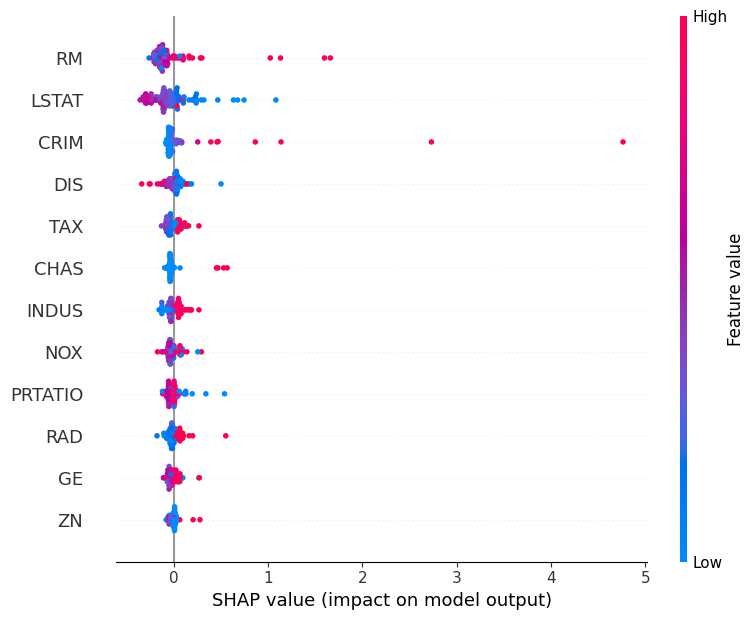

In [ ]:
shap.summary_plot(shap_values[0], x_test_std, show= False)

# Display the plot
image_name = f'../result/demo/houseprice_SHAP_xai_variance_gloabl_summary.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

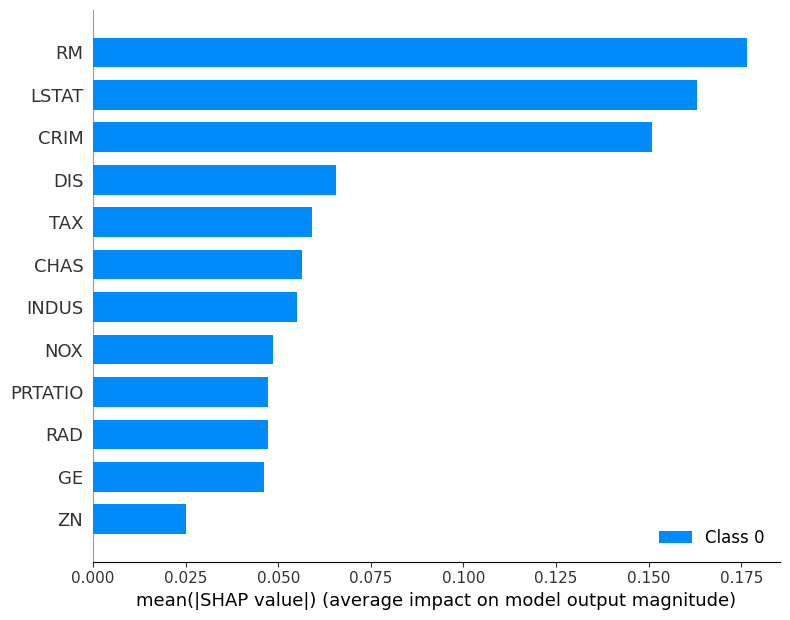

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.summary_plot(shap_values, x_test_std, show= False)     # essiently the Class Index should be added, so this code here is uncorrect!

# Display the plot
image_name = f'../result/demo/houseprice_SHAP_xai_variance_gloabl.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

### Local XAI varainces ###

In [24]:
### the sample index is randomly selected from total test data are 102 samples ### 
selected_index= random.randint(0, 101)
print('this time selected_index is:', selected_index)

this time selected_index is: 74


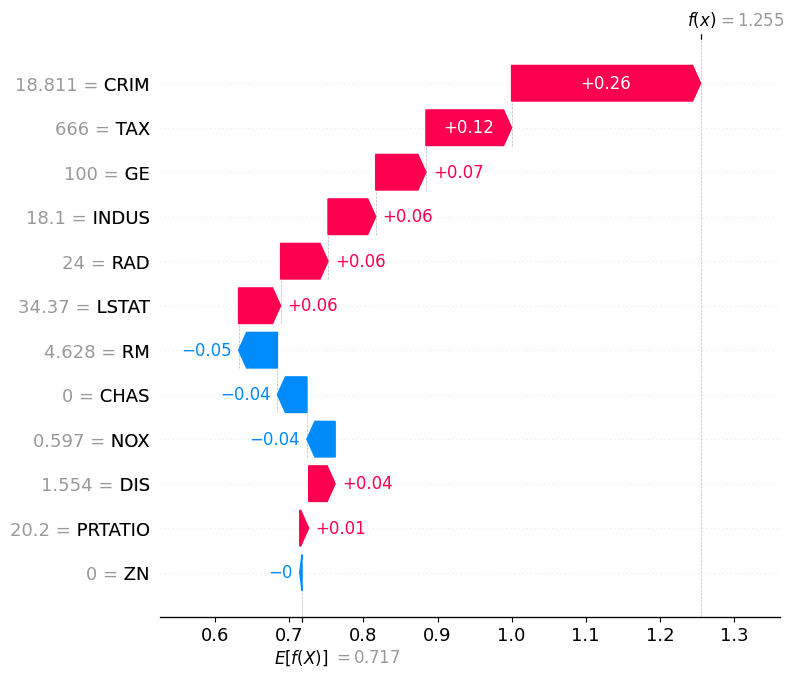

In [25]:
# Convert shap_values to shap.Explanation object using original feature values
shap_explanation = shap.Explanation(
    values=shap_values[0][selected_index],   # SHAP values
    base_values=expected_value,              # SHAP expected value
    data=pd.Series(x_test_inv[selected_index], index=x_column_names)  # reverse standardization data反标准化后的数据
)

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names), show=False)
plt.show()
plt.close()

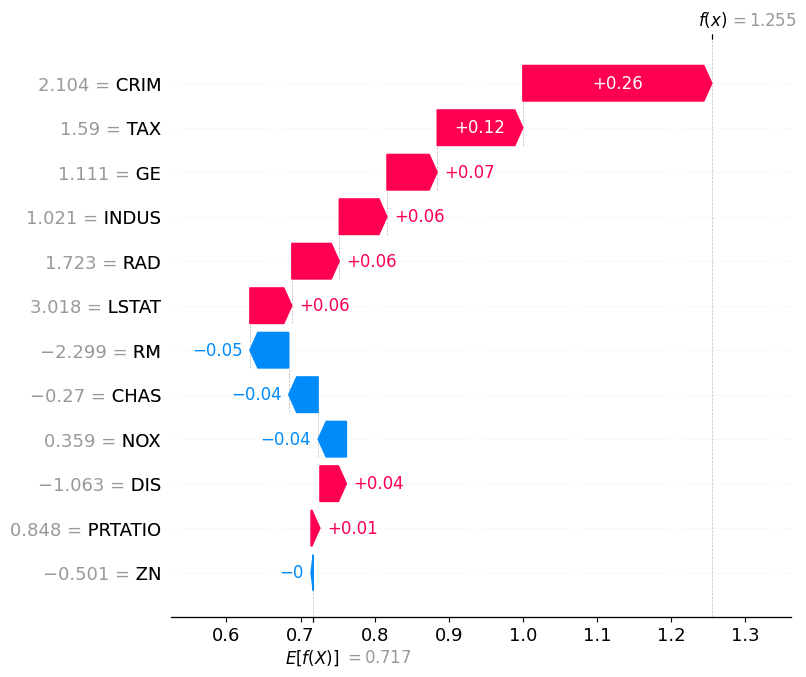

In [26]:
# Convert shap_values to shap.Explanation object
shap_explanation = shap.Explanation(values=shap_values[0][selected_index], 
									base_values=expected_value, 
									data=x_test_std.iloc[selected_index])

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)
plt.show()
plt.close()

#### the sample index is selected from y_test_top_5_max_index ####

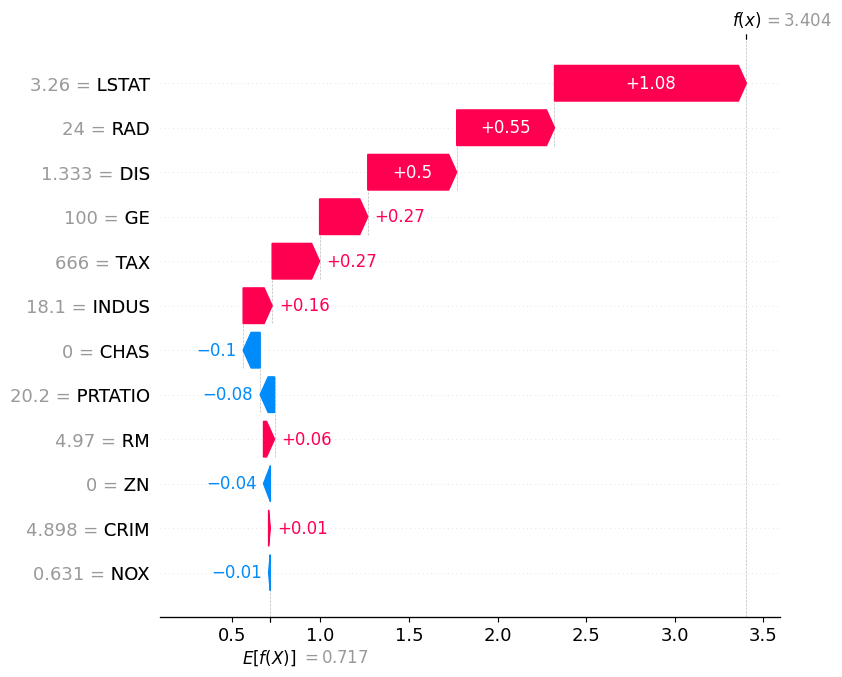

In [27]:
# Convert shap_values to shap.Explanation object using original feature values
shap_explanation = shap.Explanation(
    values=shap_values[0][y_test_top_5_max_index[0]],   # SHAP values
    base_values=expected_value,              # SHAP expected value
    data=pd.Series(x_test_inv[y_test_top_5_max_index[0]], index=x_column_names)  # reverse standardization data反标准化后的数据
)

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names), show=False)

# Display the plot
image_name = f'../result/demo/houseprice_SHAP_xai_variance_local{y_test_top_5_max_index[0]}_waterfall.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

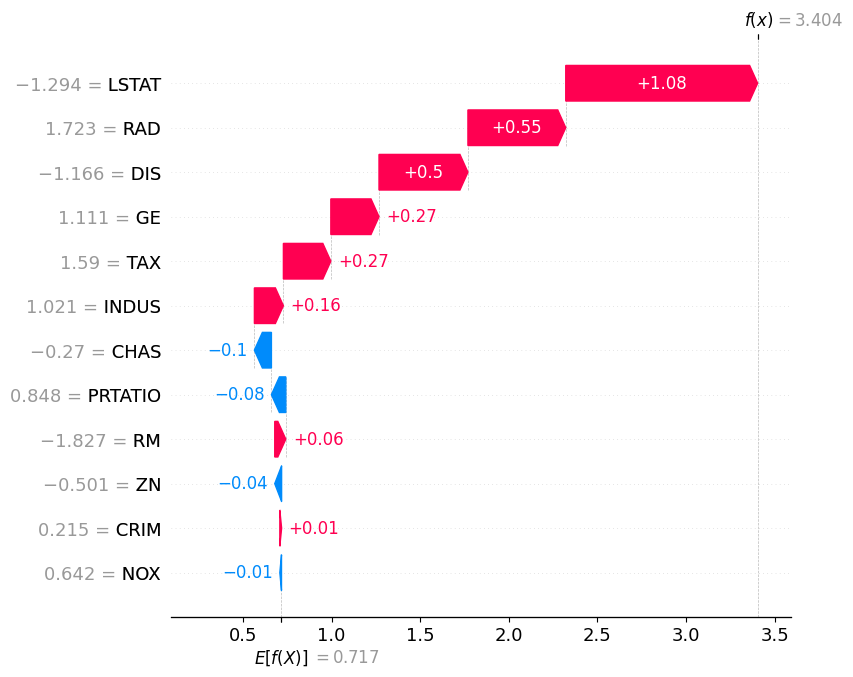

In [28]:
# Convert shap_values to shap.Explanation object
shap_explanation = shap.Explanation(values=shap_values[0][y_test_top_5_max_index[0]], 
									base_values=expected_value, 
									data=x_test_std.iloc[y_test_top_5_max_index[0]])

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)
plt.show()
plt.close()

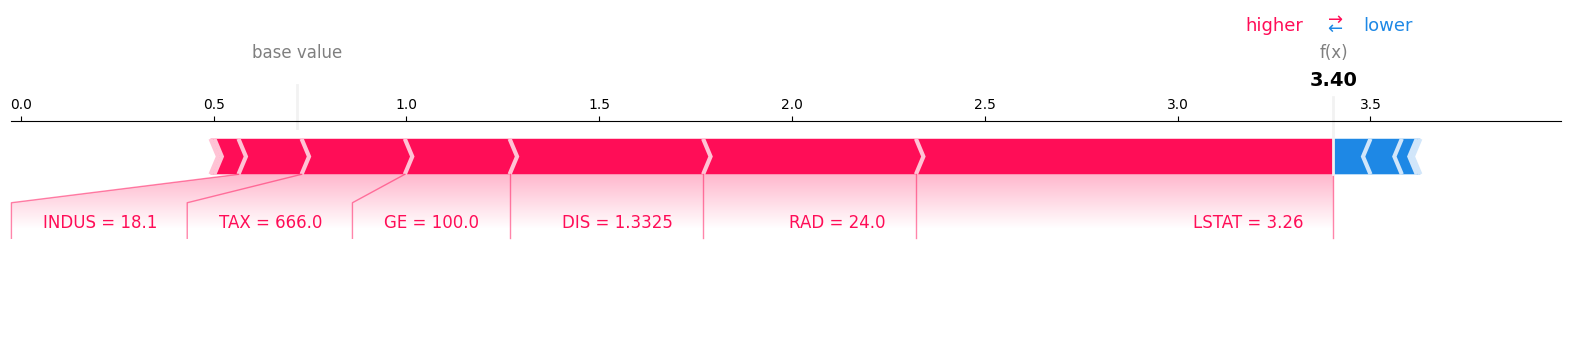

In [ ]:
# Convert shap_values to shap.Explanation object using original feature values
shap.force_plot(expected_value, 
                shap_values[0][y_test_top_5_max_index[0]], 
                pd.Series(x_test_inv[y_test_top_5_max_index[0]], index=x_column_names),   #x_test_std.iloc[0, :], 
                matplotlib= True, 
                show=False)   

# Display the plot
image_name = f'../result/demo/houseprice_SHAP_xai_variance_local{y_test_top_5_max_index[0]}_force_plot.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300) 
plt.show()
plt.close()

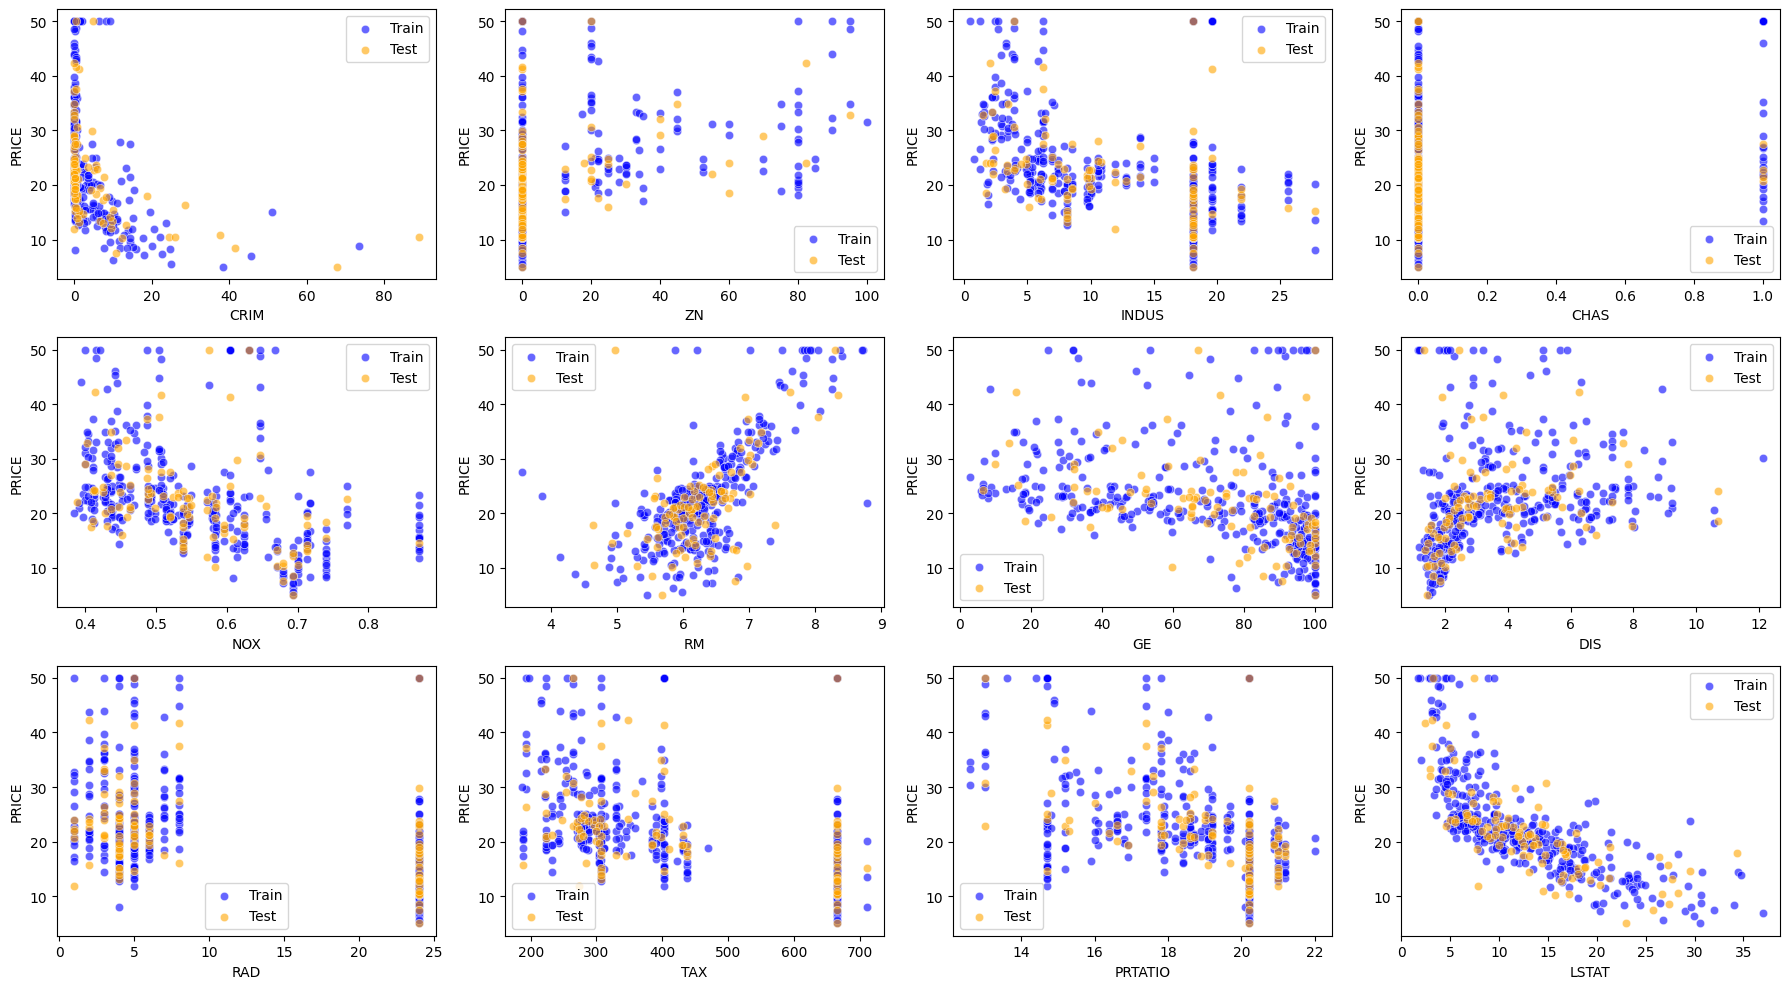

In [29]:
# Create combined scatter plots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(x_column_names):
    # Inverse-transformed data for the current column
    x_train_col = x_train_inv[:, i]
    y_train_col = y_train_inv[:, 0]  # Assuming y_train has one column
    x_test_col = x_test_inv[:, i]
    y_test_col = y_test_inv[:, 0]  # Assuming y_test has one column

    # Create scatter plots
    sns.scatterplot(x=x_train_col, y=y_train_col, ax=axes[i], color='blue', label='Train', alpha=0.6)
    sns.scatterplot(x=x_test_col, y=y_test_col, ax=axes[i], color='orange', label='Test', alpha=0.6)

    # Set titles and labels
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('PRICE')
    axes[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
plt.close()